# Panel Analysis with County Data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from linearmodels import PanelOLS

In [2]:
GLOBAL_CUTOFF = [0.1, 0.9]

In [3]:
DATA_DIR = "../data/cleaned-data/"

In [4]:
data = pd.read_csv(DATA_DIR + "countyincome_gini_const.csv")
data.head()

,YEAR,GEOFIPS,GINI,NUM_RETURN,NUM_EXEMPT,AGI,WAGES_SALARIES,DIVIDENDS,INTEREST,TAXABLE_TOTAL
0,1989,1001,0.400131,13674.0,31869.0,333060.0,279230.0,3115.0,13269.0,295614.0
1,1989,1003,0.425340,39202.0,86819.0,957370.0,673040.0,24108.0,82778.0,779926.0
2,1989,1005,0.480382,9367.0,21385.0,193510.0,153190.0,2729.0,12946.0,168865.0
3,1989,1007,0.452399,6347.0,15087.0,129680.0,107400.0,924.0,5794.0,114118.0
4,1989,1009,0.419520,13270.0,31010.0,294430.0,241690.0,1984.0,14595.0,258269.0


In [5]:
data.describe()

,YEAR,GEOFIPS,GINI,NUM_RETURN,NUM_EXEMPT,AGI,WAGES_SALARIES,DIVIDENDS,INTEREST,TAXABLE_TOTAL
count,94953.000000,94953.000000,94953.000000,9.495300e+04,9.495300e+04,9.495300e+04,9.495300e+04,9.495300e+04,9.495300e+04,9.495300e+04
mean,2004.000000,30960.070846,0.434141,3.496766e+04,7.222695e+04,1.867418e+06,1.354905e+06,4.082650e+04,4.732467e+04,1.443057e+06
std,8.944319,14849.532922,0.038283,9.791679e+04,1.976223e+05,6.516120e+06,4.575418e+06,2.176714e+05,2.634287e+05,4.918782e+06
min,1989.000000,1001.000000,0.271210,-1.000000e+00,-1.000000e+00,-1.987830e+05,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00
25%,1996.000000,19099.000000,0.407577,4.162000e+03,9.130000e+03,1.396770e+05,1.006750e+05,1.626000e+03,3.705000e+03,1.081180e+05
50%,2004.000000,30017.000000,0.431576,9.480000e+03,2.061800e+04,3.555580e+05,2.600860e+05,4.692000e+03,9.098000e+03,2.761550e+05
75%,2012.000000,46025.000000,0.457919,2.450000e+04,5.246900e+04,1.046445e+06,7.635120e+05,1.642400e+04,2.495300e+04,8.074260e+05
max,2019.000000,56045.000000,0.696200,2.553690e+06,5.042326e+06,2.146214e+08,1.459489e+08,1.321019e+07,5.264664e+07,1.561677e+08


In [6]:
error_geofips = []
for col in data.columns:
    error_geofips += list(data[data[col] <= 0]["GEOFIPS"])
error_geofips = list(set(error_geofips))
error_geofips

[31009,
 16033,
 46017,
 51685,
 38087,
 51049,
 31115,
 48269,
 16047,
 18101,
 48311,
 20089]

In [7]:
data = data[np.invert(data["GEOFIPS"].isin(error_geofips))]
data.shape

(94581, 10)

In [8]:
data.describe()

,YEAR,GEOFIPS,GINI,NUM_RETURN,NUM_EXEMPT,AGI,WAGES_SALARIES,DIVIDENDS,INTEREST,TAXABLE_TOTAL
count,94581.000000,94581.000000,94581.000000,9.458100e+04,9.458100e+04,9.458100e+04,9.458100e+04,9.458100e+04,9.458100e+04,9.458100e+04
mean,2004.000000,30945.553917,0.434223,3.509804e+04,7.249516e+04,1.874492e+06,1.360019e+06,4.098445e+04,4.750398e+04,1.448507e+06
std,8.944319,14851.799975,0.038155,9.808696e+04,1.979639e+05,6.527940e+06,4.583676e+06,2.180844e+05,2.639307e+05,4.927673e+06
min,1989.000000,1001.000000,0.300186,1.210000e+02,2.450000e+02,1.464000e+03,2.110000e+02,8.000000e+00,1.600000e+01,9.840000e+02
25%,1996.000000,19099.000000,0.407707,4.194000e+03,9.210000e+03,1.409170e+05,1.016750e+05,1.644000e+03,3.738000e+03,1.091110e+05
50%,2004.000000,30013.000000,0.431693,9.540000e+03,2.073200e+04,3.578220e+05,2.618000e+05,4.727000e+03,9.166000e+03,2.779100e+05
75%,2012.000000,46023.000000,0.457928,2.461500e+04,5.275000e+04,1.051627e+06,7.666290e+05,1.651100e+04,2.508200e+04,8.121450e+05
max,2019.000000,56045.000000,0.696200,2.553690e+06,5.042326e+06,2.146214e+08,1.459489e+08,1.321019e+07,5.264664e+07,1.561677e+08


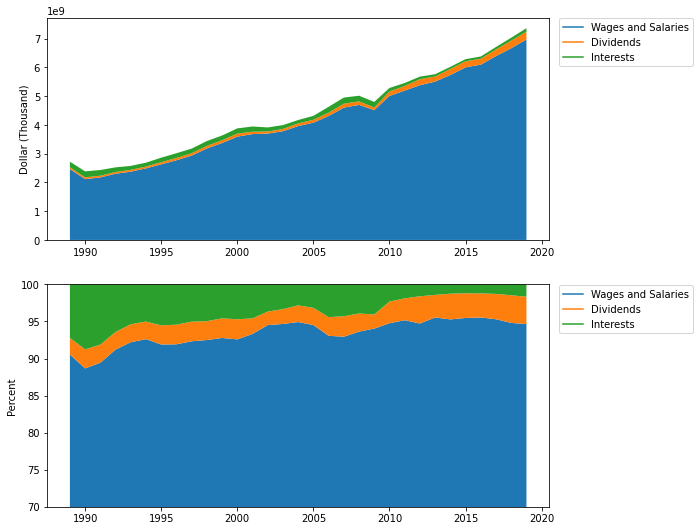

In [9]:
data_mean_by_year = data.groupby("YEAR")[["WAGES_SALARIES", "DIVIDENDS", "INTEREST", "TAXABLE_TOTAL"]].sum()

fig,(ax1, ax2) = plt.subplots(2, 1)
fig.set_figheight(9)
fig.set_figwidth(9)
# Plot x-labels, y-label and data
ax1.plot([], [], color = "tab:blue",
         label ='Wages and Salaries')
ax1.plot([], [], color = "tab:orange",
         label ='Dividends')
ax1.plot([], [], color = "tab:green",
         label ='Interests')
ax1.stackplot(data_mean_by_year.index, data_mean_by_year["WAGES_SALARIES"], data_mean_by_year["DIVIDENDS"], data_mean_by_year["INTEREST"])
ax1.set_ylabel("Dollar (Thousand)")
ax1.legend(loc=(1.02,0.78))

# Plot x-labels, y-label and data
ax2.plot([], [], color = "tab:blue",
         label ='Wages and Salaries')
ax2.plot([], [], color = "tab:orange",
         label ='Dividends')
ax2.plot([], [], color = "tab:green",
         label ='Interests')

WAGES_SALARIES = data_mean_by_year["WAGES_SALARIES"] / data_mean_by_year["TAXABLE_TOTAL"] * 100, 
DIVIDENDS = data_mean_by_year["DIVIDENDS"] / data_mean_by_year["TAXABLE_TOTAL"] * 100, 
INTEREST = data_mean_by_year["INTEREST"] / data_mean_by_year["TAXABLE_TOTAL"] * 100

ax2.stackplot(data_mean_by_year.index, WAGES_SALARIES, DIVIDENDS, INTEREST)
ax2.set_ylabel("Percent")
ax2.legend(loc=(1.02,0.78))
ax2.set_ylim(70, 100)
plt.show()

## Prepare Data

In [10]:
aggregate = pd.DataFrame(data.groupby("YEAR")[["TAXABLE_TOTAL", "AGI", "WAGES_SALARIES", "DIVIDENDS", "INTEREST"]].sum()).reset_index()
aggregate.rename(columns={"TAXABLE_TOTAL": "AGGREGATE_TAXABLE_TOTAL", 
                          "AGI": "AGGREGATE_AGI", 
                          "WAGES_SALARIES": "AGGREGATE_WAGES_SALARIES", 
                          "DIVIDENDS": "AGGREGATE_DIVIDENDS", 
                          "INTEREST": "AGGREGATE_INTEREST"}, inplace=True)

In [11]:
data = data.merge(aggregate, left_on="YEAR", right_on="YEAR")

In [12]:
data_change = data.sort_values(by=["GEOFIPS", "YEAR"], ascending=True).set_index(["YEAR", "GEOFIPS", "GINI"]).pct_change().reset_index()
data_change = data_change[data_change["YEAR"] > 1989]
data_change

,YEAR,GEOFIPS,GINI,NUM_RETURN,NUM_EXEMPT,AGI,WAGES_SALARIES,DIVIDENDS,INTEREST,TAXABLE_TOTAL,AGGREGATE_TAXABLE_TOTAL,AGGREGATE_AGI,AGGREGATE_WAGES_SALARIES,AGGREGATE_DIVIDENDS,AGGREGATE_INTEREST
1,1990,1001,0.400131,-0.057847,-0.011861,0.046334,0.053898,-0.226966,0.021705,0.049494,-0.123073,-0.309019,-0.141230,0.008563,0.063839
2,1991,1001,0.400131,0.027090,0.026388,0.072343,0.061156,0.191445,0.002213,0.059592,0.019234,0.020797,0.028003,-0.030873,-0.054807
3,1992,1001,0.400131,0.016551,0.017388,0.071576,0.071366,-0.008714,-0.143814,0.061774,0.038077,0.054306,0.058766,0.008214,-0.180679
4,1993,1001,0.400131,0.039402,0.033968,0.059955,0.061450,0.157876,-0.146910,0.055292,0.020228,0.027664,0.031260,0.043717,-0.145406
5,1994,1001,0.400131,0.030184,0.019117,0.104980,0.071615,0.070452,0.011689,0.069990,0.043472,0.047956,0.048196,0.018019,-0.026120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94576,2015,56045,0.421600,-0.006042,-0.015291,0.017900,0.020256,-0.222190,-0.178397,0.012770,0.044352,0.039111,0.046528,0.001951,-0.003726
94577,2016,56045,0.410900,-0.045593,-0.035714,-0.134465,-0.113626,0.050433,0.014419,-0.109729,0.014741,0.004504,0.015445,-0.011257,0.030958
94578,2017,56045,0.410900,-0.015924,-0.012882,-0.047289,-0.003628,0.082408,1.152174,0.008472,0.051849,0.074555,0.049200,0.108694,0.108404
94579,2018,56045,0.410900,0.000000,-0.009788,0.027848,0.031129,-0.166170,-0.242813,0.021506,0.047992,0.057876,0.042559,0.143275,0.198122


In [13]:
cols = ["NUM_RETURN", "NUM_EXEMPT", "AGI", "WAGES_SALARIES", "DIVIDENDS", "INTEREST", "TAXABLE_TOTAL", 
        "AGGREGATE_TAXABLE_TOTAL", "AGGREGATE_AGI", "AGGREGATE_WAGES_SALARIES", "AGGREGATE_DIVIDENDS", "AGGREGATE_INTEREST"]
for col in cols:
    data_change[col] = data_change[col].map(lambda x: x * 100)
data_change

,YEAR,GEOFIPS,GINI,NUM_RETURN,NUM_EXEMPT,AGI,WAGES_SALARIES,DIVIDENDS,INTEREST,TAXABLE_TOTAL,AGGREGATE_TAXABLE_TOTAL,AGGREGATE_AGI,AGGREGATE_WAGES_SALARIES,AGGREGATE_DIVIDENDS,AGGREGATE_INTEREST
1,1990,1001,0.400131,-5.784701,-1.186106,4.633399,5.389822,-22.696629,2.170473,4.949360,-12.307316,-30.901946,-14.123012,0.856282,6.383944
2,1991,1001,0.400131,2.708996,2.638849,7.234312,6.115604,19.144518,0.221288,5.959161,1.923444,2.079702,2.800259,-3.087279,-5.480742
3,1992,1001,0.400131,1.655079,1.738754,7.157556,7.136613,-0.871384,-14.381394,6.177354,3.807745,5.430620,5.876627,0.821441,-18.067890
4,1993,1001,0.400131,3.940227,3.396789,5.995490,6.145031,15.787623,-14.690965,5.529166,2.022772,2.766388,3.126031,4.371680,-14.540557
5,1994,1001,0.400131,3.018382,1.911708,10.498045,7.161483,7.045247,1.168884,6.998987,4.347175,4.795611,4.819628,1.801914,-2.611980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94576,2015,56045,0.421600,-0.604230,-1.529052,1.789975,2.025623,-22.218970,-17.839721,1.276999,4.435159,3.911094,4.652777,0.195135,-0.372631
94577,2016,56045,0.410900,-4.559271,-3.571429,-13.446539,-11.362599,5.043282,1.441900,-10.972930,1.474106,0.450449,1.544481,-1.125657,3.095825
94578,2017,56045,0.410900,-1.592357,-1.288245,-4.728889,-0.362815,8.240774,115.217391,0.847249,5.184895,7.455546,4.920041,10.869439,10.840437
94579,2018,56045,0.410900,0.000000,-0.978793,2.784802,3.112898,-16.617014,-24.281274,2.150617,4.799178,5.787627,4.255853,14.327542,19.812232


In [14]:
data_change.shape

(91530, 15)

In [15]:
cols = ['NUM_RETURN', 'NUM_EXEMPT', 'AGI',
       'WAGES_SALARIES', 'DIVIDENDS', 'INTEREST', 'TAXABLE_TOTAL',
       'AGGREGATE_TAXABLE_TOTAL', 'AGGREGATE_AGI', 'AGGREGATE_WAGES_SALARIES',
       'AGGREGATE_DIVIDENDS', 'AGGREGATE_INTEREST']
outlier_geofips = []
for col in cols:
    outlier_geofips += list(data_change[(data_change[col] < -50.0) | (data_change[col] > 100.0)]["GEOFIPS"])
outlier_geofips = list(set(outlier_geofips))
outlier_geofips

[47105,
 2050,
 47111,
 47115,
 2060,
 47117,
 2070,
 47127,
 47129,
 47135,
 47145,
 41003,
 47151,
 47155,
 2100,
 47159,
 41021,
 2110,
 41023,
 41027,
 47171,
 47175,
 2122,
 47185,
 2130,
 39011,
 2150,
 41067,
 41069,
 2164,
 2170,
 39041,
 39043,
 2180,
 21193,
 2185,
 39049,
 2188,
 39063,
 37017,
 39067,
 37021,
 39077,
 37035,
 2220,
 37037,
 37041,
 39091,
 37047,
 37057,
 35011,
 39109,
 35015,
 35019,
 35021,
 35023,
 37071,
 37073,
 35027,
 39125,
 35037,
 48121,
 35041,
 35043,
 35045,
 35047,
 39145,
 37097,
 33003,
 2290,
 35059,
 33011,
 37109,
 39161,
 31003,
 31005,
 31007,
 31011,
 48091,
 31019,
 37167,
 31027,
 31029,
 51510,
 31031,
 55015,
 51520,
 31049,
 51530,
 29003,
 29005,
 29011,
 51540,
 29013,
 31061,
 31063,
 29017,
 31069,
 51550,
 31071,
 29025,
 31075,
 31081,
 31085,
 31087,
 51570,
 31095,
 51580,
 31103,
 48109,
 27011,
 31109,
 51590,
 31113,
 51595,
 29067,
 29069,
 31119,
 51600,
 27023,
 27029,
 31125,
 51610,
 27039,
 31135,
 48115,
 27043,

In [19]:
data_change[data_change["GEOFIPS"]==51031]

,YEAR,GEOFIPS,GINI,NUM_RETURN,NUM_EXEMPT,AGI,WAGES_SALARIES,DIVIDENDS,INTEREST,TAXABLE_TOTAL,AGGREGATE_TAXABLE_TOTAL,AGGREGATE_AGI,AGGREGATE_WAGES_SALARIES,AGGREGATE_DIVIDENDS,AGGREGATE_INTEREST
85127,1990,51031,0.383936,-7.269454,-2.402604,-89.368564,5.065593,-7.686478,-4.056469,4.106441,-12.307316,-30.901946,-14.123012,0.856282,6.383944
85128,1991,51031,0.383936,0.587328,0.507027,-0.348030,1.557966,5.429811,-6.047679,1.070416,1.923444,2.079702,2.800259,-3.087279,-5.480742
85129,1992,51031,0.383936,0.766985,0.891672,3.800538,4.232300,-0.923248,-21.112676,2.431616,3.807745,5.430620,5.876627,0.821441,-18.067890
85130,1993,51031,0.383936,1.487920,0.846510,5.134467,5.378275,8.824520,-9.900918,4.642117,2.022772,2.766388,3.126031,4.371680,-14.540557
85131,1994,51031,0.383936,2.041903,1.000326,5.287061,4.937230,1.196740,-8.486294,4.270782,4.347175,4.795611,4.819628,1.801914,-2.611980
85132,1995,51031,0.383936,14.130589,13.125202,16.717876,17.027373,9.297584,17.110669,16.899054,6.442695,7.039955,5.610776,16.002984,17.294475
85133,1996,51031,0.396444,-1.229798,-1.947051,0.523022,-0.643059,-2.098685,1.882451,-0.566836,5.418734,7.361927,5.447856,8.176301,3.645375
85134,1997,51031,0.396444,-1.425987,-1.960480,2.978857,2.258154,2.915396,-5.539305,1.954027,5.323299,6.879288,5.794485,5.090046,-2.537466
85135,1998,51031,0.396444,-3.285824,-3.603390,3.404512,1.468325,0.981300,3.861080,1.550015,8.313819,10.075944,8.508517,4.191820,6.905229
85136,1999,51031,0.396444,6.252206,5.278508,8.027414,8.981086,21.342134,4.695048,9.011762,5.582042,6.801216,5.902076,9.903204,-2.600898


In [16]:
data_change = data_change[np.invert(data_change["GEOFIPS"].isin(outlier_geofips))]
data_change.shape

(58230, 15)

In [17]:
print(data_change.replace([np.inf, -np.inf], np.nan) \
    .dropna(how="all").describe().T[["mean", "std", "min", "max"]].to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &          mean &           std &          min &           max \\
\midrule
YEAR                     &   2004.500000 &      8.655516 &  1990.000000 &   2019.000000 \\
GEOFIPS                  &  30365.269964 &  14182.587433 &  1001.000000 &  56037.000000 \\
GINI                     &      0.433774 &      0.035606 &     0.315090 &      0.652400 \\
NUM\_RETURN               &      1.103175 &      5.409439 &   -40.248447 &     86.448490 \\
NUM\_EXEMPT               &      0.552948 &      3.939205 &   -41.443850 &     92.257218 \\
AGI                      &      4.216950 &      6.177761 &   -41.362484 &     99.340849 \\
WAGES\_SALARIES           &      3.968428 &      4.366135 &   -42.370681 &     91.398905 \\
DIVIDENDS                &      5.261701 &     17.453325 &   -49.986402 &     99.926713 \\
INTEREST                 &     -1.779972 &     17.018714 &   -49.964101 &     98.348813 \\
TAXABLE\_TOTAL            &      3.633170 &      4.446001 &   -41.73

## Evaluate PanelOLS

In [18]:
def evaluate(data_change, y="AGI", cutoff=GLOBAL_CUTOFF, time_effects=True, entity_effects=True, show_result=True):
    gini_ranking = np.array(data_change.groupby("GEOFIPS")["GINI"].mean().sort_values().index)
    high_gini_counties = gini_ranking[round(len(gini_ranking) * cutoff[1]):]
    low_gini_counties = gini_ranking[:round(len(gini_ranking) * cutoff[0])]
    
    df_high_gini = data_change[data_change["GEOFIPS"].isin(high_gini_counties)].copy()
    df_high_gini["HIGH_GINI"] = np.ones(df_high_gini.shape[0])
    df_low_gini = data_change[data_change["GEOFIPS"].isin(low_gini_counties)].copy()
    df_low_gini["HIGH_GINI"] = np.zeros(df_low_gini.shape[0])
    
    df_merged = pd.concat([df_high_gini, df_low_gini])
    aggregate_variable = "AGGREGATE_" + y
#     df_merged["AGGREGATE_TAXABLE_TOTAL*HIGH_GINI"] = df_merged["AGGREGATE_TAXABLE_TOTAL"] * df_merged["HIGH_GINI"]
    df_merged[aggregate_variable + "*HIGH_GINI"] = df_merged[aggregate_variable] * df_merged["HIGH_GINI"]
    df_merged.set_index(["YEAR", "GEOFIPS"], inplace=True)
    df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_merged.dropna(inplace=True)
    
    exog = sm.add_constant(df_merged[[aggregate_variable + "*HIGH_GINI"]])
    model = PanelOLS(df_merged[y], exog, time_effects=time_effects, entity_effects=entity_effects)
    res = model.fit(cov_type="robust")
    if show_result:
        print(res)
    
    return [res.params[1], res.std_errors[1]]

### All

In [19]:
evaluate(data_change)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    AGI   R-squared:                        0.0018
Estimator:                   PanelOLS   R-squared (Between):              0.0624
No. Observations:               11640   R-squared (Within):              -0.0012
Date:                Fri, Apr 29 2022   R-squared (Overall):              0.0154
Time:                        16:53:58   Log-likelihood                -3.592e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      20.151
Entities:                          30   P-value                           0.0000
Avg Obs:                       388.00   Distribution:                 F(1,11222)
Min Obs:                       388.00                                           
Max Obs:                       388.00   F-statistic (robust):             21.137
                            

[0.057439414419256214, 0.012493582107642967]

In [20]:
evaluate(data_change, time_effects=False, entity_effects=True)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    AGI   R-squared:                      8.92e-05
Estimator:                   PanelOLS   R-squared (Between):              0.0140
No. Observations:               11640   R-squared (Within):             8.92e-05
Date:                Fri, Apr 29 2022   R-squared (Overall):              0.0037
Time:                        16:53:58   Log-likelihood                -3.636e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      1.0356
Entities:                          30   P-value                           0.3089
Avg Obs:                       388.00   Distribution:                 F(1,11609)
Min Obs:                       388.00                                           
Max Obs:                       388.00   F-statistic (robust):             0.9033
                            

[0.012130165200712147, 0.012762871454506447]

In [21]:
evaluate(data_change, time_effects=True, entity_effects=False)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    AGI   R-squared:                        0.0425
Estimator:                   PanelOLS   R-squared (Between):              0.1939
No. Observations:               11640   R-squared (Within):              -0.0293
Date:                Fri, Apr 29 2022   R-squared (Overall):              0.0288
Time:                        16:53:58   Log-likelihood                -3.754e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      499.25
Entities:                          30   P-value                           0.0000
Avg Obs:                       388.00   Distribution:                 F(1,11251)
Min Obs:                       388.00                                           
Max Obs:                       388.00   F-statistic (robust):             187.01
                            

[0.2321603922028599, 0.01697693043897695]

In [22]:
evaluate(data_change, time_effects=False, entity_effects=False)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    AGI   R-squared:                        0.0301
Estimator:                   PanelOLS   R-squared (Between):              0.1711
No. Observations:               11640   R-squared (Within):              -0.0194
Date:                Fri, Apr 29 2022   R-squared (Overall):              0.0301
Time:                        16:53:58   Log-likelihood                -3.793e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      361.47
Entities:                          30   P-value                           0.0000
Avg Obs:                       388.00   Distribution:                 F(1,11638)
Min Obs:                       388.00                                           
Max Obs:                       388.00   F-statistic (robust):             181.13
                            

[0.19143955485321149, 0.014224579609027664]

### Wages and Salaries

In [23]:
evaluate(data_change, y="WAGES_SALARIES")

                          PanelOLS Estimation Summary                           
Dep. Variable:         WAGES_SALARIES   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):              0.0133
No. Observations:               11640   R-squared (Within):              -0.0016
Date:                Fri, Apr 29 2022   R-squared (Overall):              0.0018
Time:                        16:53:58   Log-likelihood                -3.219e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      1.1431
Entities:                          30   P-value                           0.2850
Avg Obs:                       388.00   Distribution:                 F(1,11222)
Min Obs:                       388.00                                           
Max Obs:                       388.00   F-statistic (robust):             1.5572
                            

[0.018568994131710183, 0.014880457508944338]

### Dividends

In [24]:
evaluate(data_change, y="DIVIDENDS")

                          PanelOLS Estimation Summary                           
Dep. Variable:              DIVIDENDS   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):              0.0218
No. Observations:               11640   R-squared (Within):           -3.908e-05
Date:                Fri, Apr 29 2022   R-squared (Overall):              0.0086
Time:                        16:53:58   Log-likelihood                -4.707e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      1.2171
Entities:                          30   P-value                           0.2699
Avg Obs:                       388.00   Distribution:                 F(1,11222)
Min Obs:                       388.00                                           
Max Obs:                       388.00   F-statistic (robust):             0.6854
                            

[0.01716857472424503, 0.020737465110237465]

### Interest

In [25]:
evaluate(data_change, y="INTEREST")

                          PanelOLS Estimation Summary                           
Dep. Variable:               INTEREST   R-squared:                        0.0026
Estimator:                   PanelOLS   R-squared (Between):              0.0552
No. Observations:               11640   R-squared (Within):               0.0026
Date:                Fri, Apr 29 2022   R-squared (Overall):              0.0409
Time:                        16:53:58   Log-likelihood                -4.208e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      29.716
Entities:                          30   P-value                           0.0000
Avg Obs:                       388.00   Distribution:                 F(1,11222)
Min Obs:                       388.00                                           
Max Obs:                       388.00   F-statistic (robust):             22.314
                            

[0.05933107065886338, 0.01256020841792293]

## Trend over time

In [26]:
def plot_trend_over_time(y="AGI", interval=10, time_effects=True, entity_effects=True, ax=None):
    coeffs = []
    stds = []
    for year in range(1989, 2010):
        data_subset = data_change[(data_change["YEAR"] >= year) & (data_change["YEAR"] <= year+10)]
        coeff, std = evaluate(data_subset, y=y, cutoff=GLOBAL_CUTOFF, time_effects=time_effects, entity_effects=entity_effects, show_result=False)
        coeffs.append(coeff)
        stds.append(std)

    # Define variables to plot
    x = np.arange(1989+interval//2, 2020-interval+interval//2)

    # Compute upper and lower bounds using chosen uncertainty measure: here
    # it is a fraction of the standard deviation of measurements at each
    # time point based on the unbiased sample variance
    lower = np.array(coeffs) - 1.96 * np.array(stds)
    upper = np.array(coeffs) + 1.96 * np.array(stds)

    # Draw plot with error band and extra formatting to match seaborn style
    if not ax:
        fig, ax = plt.subplots(figsize=(9,5))
        
    ax.plot(x, np.array(coeffs), label="Estimates")
    ax.plot(x, lower, color='tab:blue', alpha=0.1)
    ax.plot(x, upper, color='tab:blue', alpha=0.1)
    ax.fill_between(x, lower, upper, alpha=0.2, label="95% CI")
    ax.set_xticks(np.arange(1989+interval//2, 2020-interval+interval//2, 4))
#     ax.set_xlabel('Year')
#     ax.set_ylabel('Estimate')

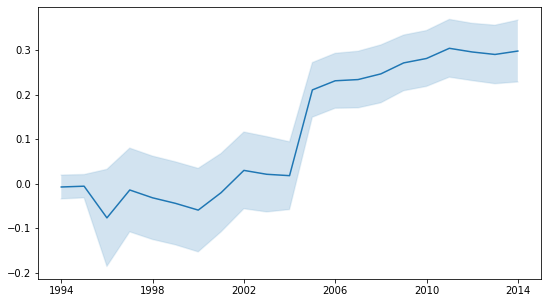

In [27]:
plot_trend_over_time()

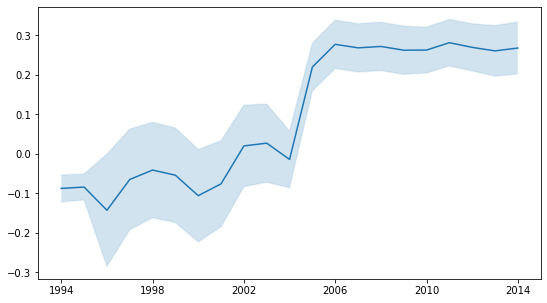

In [28]:
plot_trend_over_time(y="WAGES_SALARIES")

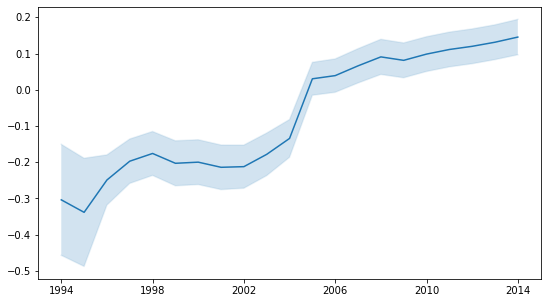

In [29]:
plot_trend_over_time(y="DIVIDENDS")

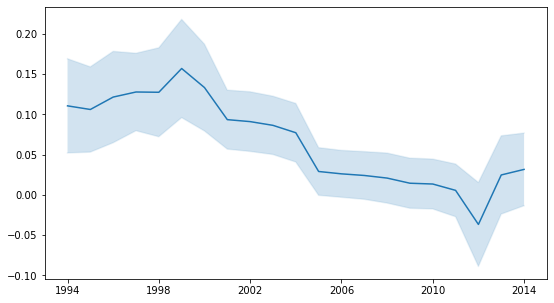

In [30]:
plot_trend_over_time(y="INTEREST")

## Propensity Score Matching

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

In [32]:
def generate_df(data_change, population_featurized, cutoff=GLOBAL_CUTOFF):
    gini_ranking = np.array(data_change.groupby("GEOFIPS")["GINI"].mean().sort_values().index)
    high_gini_counties = gini_ranking[round(len(gini_ranking) * cutoff[1]):]
    low_gini_counties = gini_ranking[:round(len(gini_ranking) * cutoff[0])]
    
    df_high_gini = population_featurized[population_featurized["GEOFIPS"].isin(high_gini_counties)].copy()
    df_high_gini["HIGH_GINI"] = np.ones(df_high_gini.shape[0])
    df_low_gini = population_featurized[population_featurized["GEOFIPS"].isin(low_gini_counties)].copy()
    df_low_gini["HIGH_GINI"] = np.zeros(df_low_gini.shape[0])
    
    psm_df = pd.concat([df_high_gini, df_low_gini]).set_index("GEOFIPS")
    
#     psm_df = pd.get_dummies(data=psm_df, drop_first=True)
    return psm_df

In [33]:
population_featurized = pd.read_csv(DATA_DIR + "population/population_featurized.csv")
features = generate_df(data_change, population_featurized)
features

,POPULATION_x_1990,POPULATION_x_1991,POPULATION_x_1992,POPULATION_x_1993,POPULATION_x_1994,POPULATION_x_1995,POPULATION_x_1996,POPULATION_x_1997,POPULATION_x_1998,POPULATION_x_1999,...,GENDER_RATIO_y_2011,GENDER_RATIO_y_2012,GENDER_RATIO_y_2013,GENDER_RATIO_y_2014,GENDER_RATIO_y_2015,GENDER_RATIO_y_2016,GENDER_RATIO_y_2017,GENDER_RATIO_y_2018,GENDER_RATIO_y_2019,HIGH_GINI
GEOFIPS,,,,,,,,,,,,,,,,,,,,,
1005,0.002311,-0.498966,-0.468490,-0.327521,0.103976,-0.576820,-0.126810,-0.357374,-0.095768,0.348482,...,-0.516873,-1.054000,-1.112672,-1.112563,-1.648008,-1.649825,-1.946171,-1.148820,-0.787769,1.0
1011,-0.427376,-0.298025,-0.846342,-1.081209,-0.629304,-0.211501,-0.446792,0.700640,0.148353,0.362752,...,-1.527546,-0.349786,-0.530368,0.244345,-2.016883,-0.717593,-1.690099,-0.526848,-1.273320,1.0
1013,0.306307,0.112633,-0.159443,-0.275924,-0.421585,-0.436336,-0.112517,-0.183188,0.738482,0.369312,...,-0.245027,-1.024767,-1.188373,-0.546128,-0.719778,-1.004989,-1.020289,-1.316929,-0.961329,1.0
1025,0.462149,-0.547941,-0.267220,-0.408832,-0.587495,0.315904,0.290405,0.067015,0.577855,0.125287,...,-0.435512,-1.356396,-0.385126,-0.869790,-0.775286,-1.215960,-1.166493,-0.872741,-1.246518,1.0
1035,0.734151,-0.365708,-0.386533,-0.620298,-0.774270,-0.333957,-1.290512,0.209076,0.239530,-0.425493,...,-0.397962,-1.587551,-1.335232,-1.547553,-0.710714,-1.059172,-0.619305,-1.195243,-1.895070,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55111,-0.742805,-0.440727,-0.566936,0.025576,-0.552574,-0.113597,-0.128355,-0.289657,-0.150601,-0.595332,...,-0.219341,-0.398290,-0.165051,-0.332744,-0.237346,-0.254128,-0.295435,-0.327775,-0.558213,0.0
55117,-0.528946,-0.040329,-0.008827,0.030589,-0.479275,-0.068701,-0.128196,-0.439641,-0.431236,-0.446483,...,-0.314847,-0.708657,-0.427127,-0.305309,-0.295621,-0.690853,-0.517486,-0.435499,-0.475877,0.0
55131,0.014941,0.148970,0.250285,0.357507,0.314169,0.564197,0.558070,0.296917,0.391990,0.176454,...,-0.093127,-0.288850,-0.415182,-0.255539,-0.254942,-0.388254,-0.248366,-0.248366,-0.275938,0.0


In [34]:
# find the most similar two GS employees for every LEH employees
def get_similar(pos_pscore, neg_pscore, topn, n_jobs=1):

    knn = NearestNeighbors(n_neighbors=topn + 1, metric='euclidean', n_jobs=n_jobs)
    knn.fit(neg_pscore)

    distances, indices = knn.kneighbors(pos_pscore)
    sim_distances = distances[:, 1:]
    sim_indices = indices[:, 1:]
    return sim_distances, sim_indices

In [35]:
pos_pscore = features[features["HIGH_GINI"] == 1]
neg_pscore = features[features["HIGH_GINI"] == 0]
sim_distances, sim_indices = get_similar(pos_pscore, neg_pscore, topn=3)
sim_indices

array([[135,  35, 191],
       [154, 155, 135],
       [151, 140, 148],
       [ 83, 148, 143],
       [135, 148, 134],
       [151, 139, 148],
       [134,  83, 155],
       [182, 191, 113],
       [189, 155, 178],
       [150,  83, 130],
       [ 83, 148, 164],
       [ 33, 150, 130],
       [105, 127, 188],
       [150, 142, 151],
       [190,  76, 173],
       [190, 104,  99],
       [182, 130, 151],
       [ 43,  56,  27],
       [130, 142, 160],
       [ 86,  50,  27],
       [160, 155, 151],
       [142, 151, 130],
       [150, 140,  39],
       [139,  98, 186],
       [ 32,   5,   0],
       [ 50,  67, 165],
       [185, 188, 105],
       [187, 104,   6],
       [104, 105,  70],
       [ 12, 102,   6],
       [105,  70, 104],
       [148, 154, 109],
       [150, 151,  56],
       [172, 104, 101],
       [ 67, 105, 127],
       [172,  82, 104],
       [176, 185, 105],
       [139, 178, 191],
       [177, 176,  34],
       [142, 151, 155],
       [189, 150, 163],
       [144,  88

In [36]:
# generate matched dataframe
psm_pos = features[features["HIGH_GINI"] == 1]
psm_neg = features[features["HIGH_GINI"] == 0].iloc[np.unique(sim_indices)]
psm_matched_df = pd.concat([psm_pos, psm_neg], axis=0)
psm_matched_df

,POPULATION_x_1990,POPULATION_x_1991,POPULATION_x_1992,POPULATION_x_1993,POPULATION_x_1994,POPULATION_x_1995,POPULATION_x_1996,POPULATION_x_1997,POPULATION_x_1998,POPULATION_x_1999,...,GENDER_RATIO_y_2011,GENDER_RATIO_y_2012,GENDER_RATIO_y_2013,GENDER_RATIO_y_2014,GENDER_RATIO_y_2015,GENDER_RATIO_y_2016,GENDER_RATIO_y_2017,GENDER_RATIO_y_2018,GENDER_RATIO_y_2019,HIGH_GINI
GEOFIPS,,,,,,,,,,,,,,,,,,,,,
1005,0.002311,-0.498966,-0.468490,-0.327521,0.103976,-0.576820,-0.126810,-0.357374,-0.095768,0.348482,...,-0.516873,-1.054000,-1.112672,-1.112563,-1.648008,-1.649825,-1.946171,-1.148820,-0.787769,1.0
1011,-0.427376,-0.298025,-0.846342,-1.081209,-0.629304,-0.211501,-0.446792,0.700640,0.148353,0.362752,...,-1.527546,-0.349786,-0.530368,0.244345,-2.016883,-0.717593,-1.690099,-0.526848,-1.273320,1.0
1013,0.306307,0.112633,-0.159443,-0.275924,-0.421585,-0.436336,-0.112517,-0.183188,0.738482,0.369312,...,-0.245027,-1.024767,-1.188373,-0.546128,-0.719778,-1.004989,-1.020289,-1.316929,-0.961329,1.0
1025,0.462149,-0.547941,-0.267220,-0.408832,-0.587495,0.315904,0.290405,0.067015,0.577855,0.125287,...,-0.435512,-1.356396,-0.385126,-0.869790,-0.775286,-1.215960,-1.166493,-0.872741,-1.246518,1.0
1035,0.734151,-0.365708,-0.386533,-0.620298,-0.774270,-0.333957,-1.290512,0.209076,0.239530,-0.425493,...,-0.397962,-1.587551,-1.335232,-1.547553,-0.710714,-1.059172,-0.619305,-1.195243,-1.895070,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55109,-0.670428,-0.173888,0.207785,0.194422,0.076429,0.694313,-0.030774,-0.149766,-0.241361,-0.183450,...,-0.072944,-0.361938,-0.055666,0.220579,-0.148077,-0.059370,0.099928,0.290654,0.086958,0.0
55111,-0.742805,-0.440727,-0.566936,0.025576,-0.552574,-0.113597,-0.128355,-0.289657,-0.150601,-0.595332,...,-0.219341,-0.398290,-0.165051,-0.332744,-0.237346,-0.254128,-0.295435,-0.327775,-0.558213,0.0
55117,-0.528946,-0.040329,-0.008827,0.030589,-0.479275,-0.068701,-0.128196,-0.439641,-0.431236,-0.446483,...,-0.314847,-0.708657,-0.427127,-0.305309,-0.295621,-0.690853,-0.517486,-0.435499,-0.475877,0.0


In [37]:
matched_counties = psm_matched_df.index
matched_counties

Int64Index([ 1005,  1011,  1013,  1025,  1035,  1041,  1047,  1065,  1073,
             1087,
            ...
            55069, 55071, 55081, 55087, 55093, 55109, 55111, 55117, 55131,
            55135],
           dtype='int64', name='GEOFIPS', length=294)

In [38]:
data_change_matched = data_change[data_change["GEOFIPS"].isin(matched_counties)].copy()
data_change_matched = data_change_matched.merge(psm_matched_df[["HIGH_GINI"]], left_on=["GEOFIPS"], right_index=True)
data_change_matched

,YEAR,GEOFIPS,GINI,NUM_RETURN,NUM_EXEMPT,AGI,WAGES_SALARIES,DIVIDENDS,INTEREST,TAXABLE_TOTAL,AGGREGATE_TAXABLE_TOTAL,AGGREGATE_AGI,AGGREGATE_WAGES_SALARIES,AGGREGATE_DIVIDENDS,AGGREGATE_INTEREST,HIGH_GINI
63,1990,1005,0.480382,-5.551404,-2.225859,2.070177,5.414192,2.931477,6.233586,5.436887,-12.307316,-30.901946,-14.123012,0.856282,6.383944,1.0
64,1991,1005,0.480382,2.283260,1.760008,5.220843,1.827426,6.657173,-3.213844,1.514215,1.923444,2.079702,2.800259,-3.087279,-5.480742,1.0
65,1992,1005,0.480382,-0.198917,0.239695,9.594954,8.197160,9.245661,-17.331530,6.334444,3.807745,5.430620,5.876627,0.821441,-18.067890,1.0
66,1993,1005,0.480382,1.195881,0.754876,4.111622,3.766989,11.029636,-11.886587,2.994417,2.022772,2.766388,3.126031,4.371680,-14.540557,1.0
67,1994,1005,0.480382,0.120363,-1.861417,8.105122,3.472072,14.639516,-3.310644,3.344852,4.347175,4.795611,4.819628,1.801914,-2.611980,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93770,2015,55135,0.414200,-0.118343,-0.969442,0.428151,1.722031,-5.225512,3.154168,1.555133,4.435159,3.911094,4.652777,0.195135,-0.372631,0.0
93771,2016,55135,0.432500,0.473934,-0.085124,0.137510,2.306796,5.744235,-5.855434,2.310361,1.474106,0.450449,1.544481,-1.125657,3.095825,0.0
93772,2017,55135,0.432500,0.039308,-0.447284,1.653742,2.659295,-3.350515,-0.839593,2.477025,5.184895,7.455546,4.920041,10.869439,10.840437,0.0
93773,2018,55135,0.432500,0.864440,0.299529,7.635636,3.491729,14.773333,18.137255,3.886254,4.799178,5.787627,4.255853,14.327542,19.812232,0.0


In [39]:
def evaluate_psm(data_change_matched, y="AGI", time_effects=True, entity_effects=True, show_result=True):
    df_merged = data_change_matched.copy()
    aggregate_variable = "AGGREGATE_" + y
#     df_merged["AGGREGATE_TAXABLE_TOTAL*HIGH_GINI"] = df_merged["AGGREGATE_TAXABLE_TOTAL"] * df_merged["HIGH_GINI"]
    df_merged[aggregate_variable + "*HIGH_GINI"] = df_merged[aggregate_variable] * df_merged["HIGH_GINI"]
    df_merged.set_index(["YEAR", "GEOFIPS"], inplace=True)
    df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_merged.dropna(inplace=True)
    
    exog = sm.add_constant(df_merged[[aggregate_variable + "*HIGH_GINI"]])
    model = PanelOLS(df_merged[y], exog, time_effects=time_effects, entity_effects=entity_effects)
    res = model.fit(cov_type="robust")
    if show_result:
        print(res)
    
    return [res.params[1], res.std_errors[1]]

In [40]:
evaluate_psm(data_change_matched)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    AGI   R-squared:                        0.0017
Estimator:                   PanelOLS   R-squared (Between):              0.0833
No. Observations:                8820   R-squared (Within):           -7.224e-05
Date:                Fri, Apr 29 2022   R-squared (Overall):              0.0225
Time:                        16:54:03   Log-likelihood                -2.717e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      14.587
Entities:                          30   P-value                           0.0001
Avg Obs:                       294.00   Distribution:                  F(1,8496)
Min Obs:                       294.00                                           
Max Obs:                       294.00   F-statistic (robust):             20.020
                            

[0.05898416553318359, 0.013182793312084816]

In [41]:
evaluate_psm(data_change_matched, time_effects=True, entity_effects=False)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    AGI   R-squared:                        0.0560
Estimator:                   PanelOLS   R-squared (Between):              0.2307
No. Observations:                8820   R-squared (Within):              -0.0226
Date:                Fri, Apr 29 2022   R-squared (Overall):              0.0459
Time:                        16:54:03   Log-likelihood                -2.839e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      505.33
Entities:                          30   P-value                           0.0000
Avg Obs:                       294.00   Distribution:                  F(1,8525)
Min Obs:                       294.00                                           
Max Obs:                       294.00   F-statistic (robust):             187.00
                            

[0.23216039220287182, 0.016977171667039558]

In [42]:
evaluate_psm(data_change_matched, time_effects=False, entity_effects=True)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    AGI   R-squared:                        0.0004
Estimator:                   PanelOLS   R-squared (Between):              0.0422
No. Observations:                8820   R-squared (Within):               0.0004
Date:                Fri, Apr 29 2022   R-squared (Overall):              0.0117
Time:                        16:54:03   Log-likelihood                -2.746e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      3.9325
Entities:                          30   P-value                           0.0474
Avg Obs:                       294.00   Distribution:                  F(1,8789)
Min Obs:                       294.00                                           
Max Obs:                       294.00   F-statistic (robust):             4.5657
                            

[0.028388559218033495, 0.013285885154908268]

In [43]:
evaluate_psm(data_change_matched, time_effects=False, entity_effects=False)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    AGI   R-squared:                        0.0464
Estimator:                   PanelOLS   R-squared (Between):              0.2196
No. Observations:                8820   R-squared (Within):              -0.0177
Date:                Fri, Apr 29 2022   R-squared (Overall):              0.0464
Time:                        16:54:03   Log-likelihood                -2.864e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      429.11
Entities:                          30   P-value                           0.0000
Avg Obs:                       294.00   Distribution:                  F(1,8818)
Min Obs:                       294.00                                           
Max Obs:                       294.00   F-statistic (robust):             190.47
                            

[0.20935051516289846, 0.015169072355927803]

In [44]:
evaluate_psm(data_change_matched, "WAGES_SALARIES")

                          PanelOLS Estimation Summary                           
Dep. Variable:         WAGES_SALARIES   R-squared:                     4.871e-05
Estimator:                   PanelOLS   R-squared (Between):              0.0120
No. Observations:                8820   R-squared (Within):              -0.0006
Date:                Fri, Apr 29 2022   R-squared (Overall):              0.0027
Time:                        16:54:03   Log-likelihood                -2.381e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.4139
Entities:                          30   P-value                           0.5200
Avg Obs:                       294.00   Distribution:                  F(1,8496)
Min Obs:                       294.00                                           
Max Obs:                       294.00   F-statistic (robust):             0.6712
                            

[0.012678968481194704, 0.015475962890140273]

In [45]:
evaluate_psm(data_change_matched, "DIVIDENDS")

                          PanelOLS Estimation Summary                           
Dep. Variable:              DIVIDENDS   R-squared:                     4.098e-05
Estimator:                   PanelOLS   R-squared (Between):              0.0194
No. Observations:                8820   R-squared (Within):            2.377e-05
Date:                Fri, Apr 29 2022   R-squared (Overall):              0.0075
Time:                        16:54:03   Log-likelihood                -3.574e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.3482
Entities:                          30   P-value                           0.5552
Avg Obs:                       294.00   Distribution:                  F(1,8496)
Min Obs:                       294.00                                           
Max Obs:                       294.00   F-statistic (robust):             0.2468
                            

[0.011232261760290515, 0.02261189835231102]

In [46]:
evaluate_psm(data_change_matched, "INTEREST")

                          PanelOLS Estimation Summary                           
Dep. Variable:               INTEREST   R-squared:                        0.0033
Estimator:                   PanelOLS   R-squared (Between):              0.0854
No. Observations:                8820   R-squared (Within):               0.0032
Date:                Fri, Apr 29 2022   R-squared (Overall):              0.0631
Time:                        16:54:03   Log-likelihood                -3.193e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      28.236
Entities:                          30   P-value                           0.0000
Avg Obs:                       294.00   Distribution:                  F(1,8496)
Min Obs:                       294.00                                           
Max Obs:                       294.00   F-statistic (robust):             24.789
                            

[0.07049439258089835, 0.014158756822737832]

In [47]:
def plot_trend_over_time_psm(y="AGI", interval=10, time_effects=True, entity_effects=True, ax=None):
    coeffs = []
    stds = []
    for year in range(1989, 2010):
        data_subset = data_change_matched[(data_change_matched["YEAR"] >= year) & (data_change_matched["YEAR"] <= year+10)]
        coeff, std = evaluate_psm(data_subset, y=y, time_effects=time_effects, entity_effects=entity_effects, show_result=False)
        coeffs.append(coeff)
        stds.append(std)

    # Define variables to plot
    x = np.arange(1989+interval//2, 2020-interval+interval//2)

    # Compute upper and lower bounds using chosen uncertainty measure: here
    # it is a fraction of the standard deviation of measurements at each
    # time point based on the unbiased sample variance
    lower = np.array(coeffs) - 1.96 * np.array(stds)
    upper = np.array(coeffs) + 1.96 * np.array(stds)

    # Draw plot with error band and extra formatting to match seaborn style
    if not ax:
        fig, ax = plt.subplots(figsize=(9,5))
        
    ax.plot(x, np.array(coeffs), label="Estimates")
    ax.plot(x, lower, color='tab:blue', alpha=0.1)
    ax.plot(x, upper, color='tab:blue', alpha=0.1)
    ax.fill_between(x, lower, upper, alpha=0.2, label="95% CI")
    ax.set_xticks(np.arange(1989+interval//2, 2020-interval+interval//2, 4))
#     ax.set_xlabel('Year')
#     ax.set_ylabel('Estimate')

In [48]:
def plot_all_categories(plot_fn, interval=10, time_effects=True, entity_effects=True, sharey=True):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=sharey, figsize=(14,10))
    plt.figure(dpi=400)
    
    plot_fn(ax=ax1)
    ax1.axhline(y=0, color='grey', linestyle='dashed')
    ax1.set_title("Overall", fontsize=14)
    
    plot_fn(y="WAGES_SALARIES", ax=ax2)
    ax2.axhline(y=0, color='grey', linestyle='dashed')
    ax2.set_title("Taxable Wages and Salaries", fontsize=14)
    
    plot_fn(y="DIVIDENDS", ax=ax3)
    ax3.axhline(y=0, color='grey', linestyle='dashed')
    ax3.set_title("Taxable Dividend Income", fontsize=14)
    plot_fn(y="INTEREST", ax=ax4)
    ax4.axhline(y=0, color='grey', linestyle='dashed')
    ax4.set_title("Taxable Interest Income", fontsize=14)
    handles, labels = ax1.get_legend_handles_labels()
    
#     fig.legend(handles, labels, fontsize=14, loc=(0.45, -0.02))
    fig.tight_layout()
    

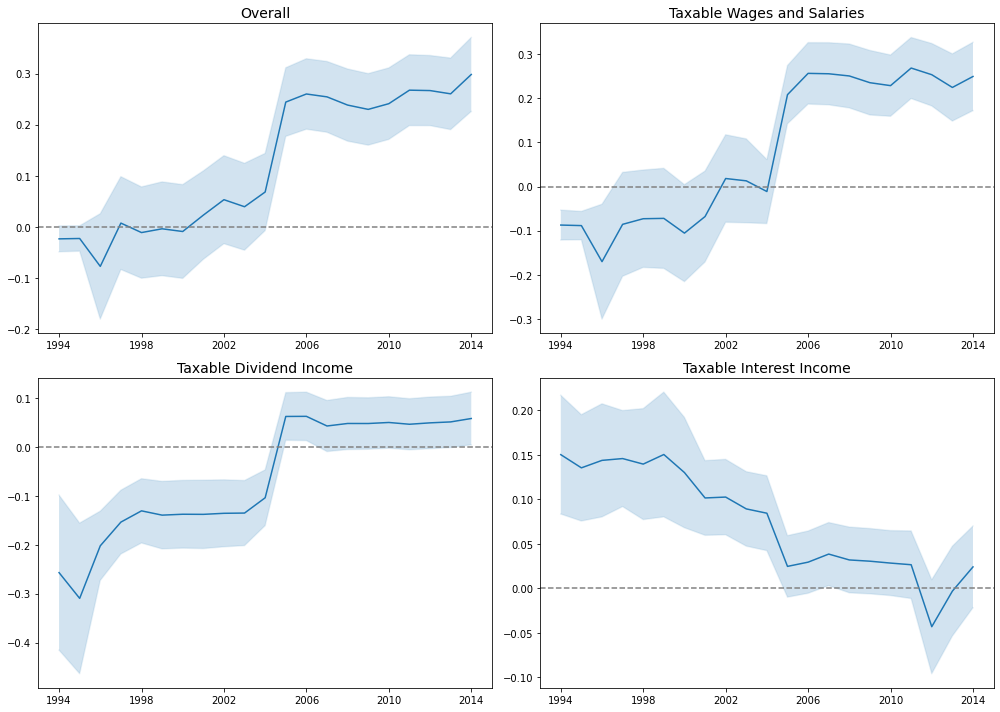

<Figure size 2400x1600 with 0 Axes>

In [49]:
plot_all_categories(plot_trend_over_time_psm, sharey=False)

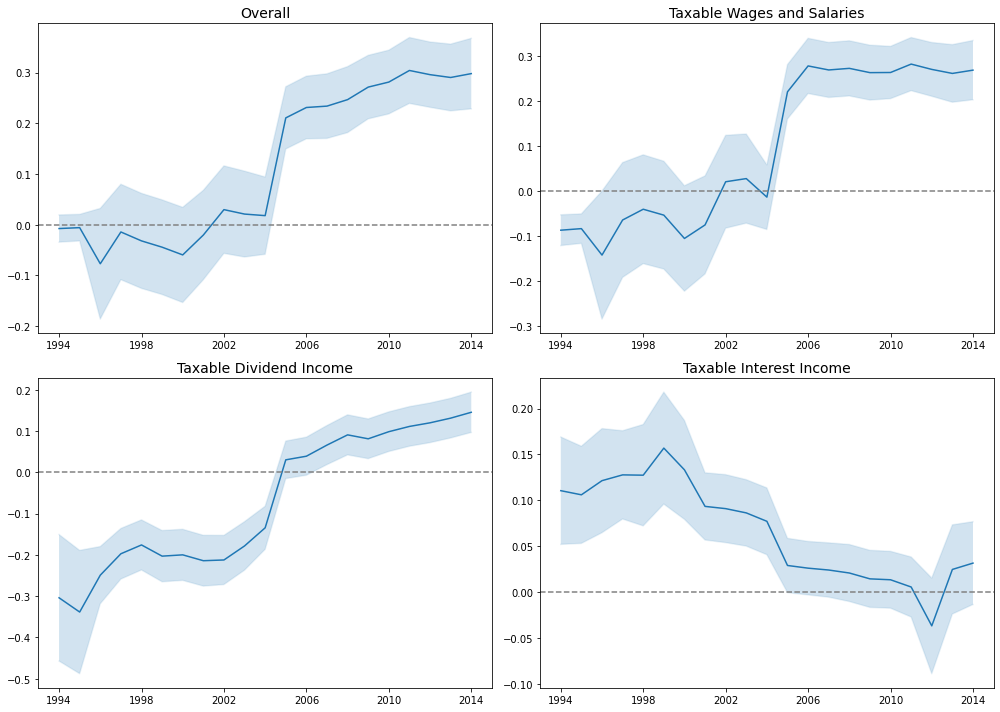

<Figure size 2400x1600 with 0 Axes>

In [50]:
plot_all_categories(plot_trend_over_time, sharey=False)

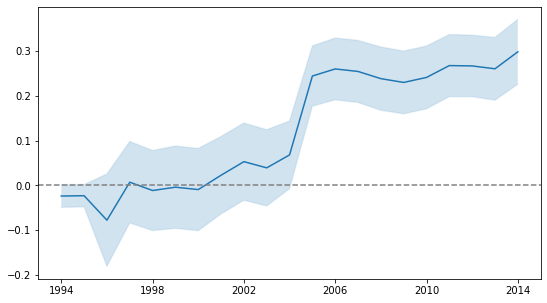

In [51]:
plot_trend_over_time_psm()
plt.axhline(y=0, color='grey', linestyle='dashed')

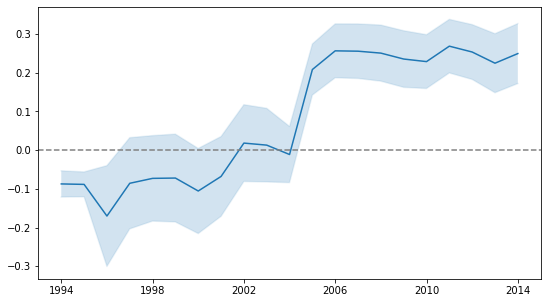

In [52]:
plot_trend_over_time_psm("WAGES_SALARIES")
plt.axhline(y=0, color='grey', linestyle='dashed')

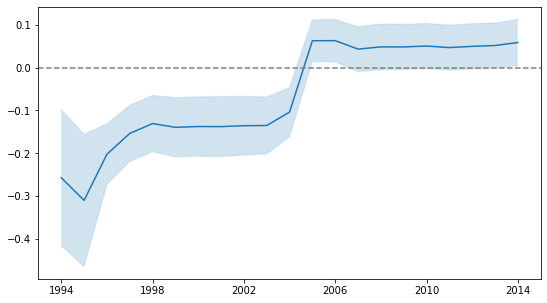

In [53]:
plot_trend_over_time_psm("DIVIDENDS")
plt.axhline(y=0, color='grey', linestyle='dashed')

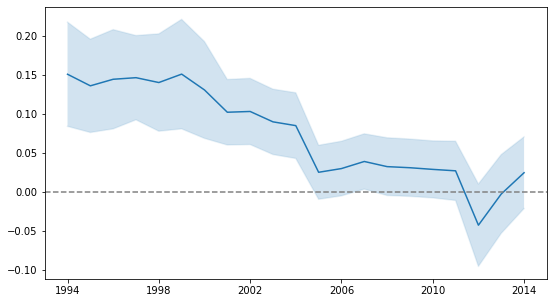

In [54]:
plot_trend_over_time_psm("INTEREST")
plt.axhline(y=0, color='grey', linestyle='dashed')

In [55]:
income_composition = pd.read_csv(DATA_DIR + "income_composition_numeric.csv")
income_composition.head()

,year,labor,business,capital,other_market,social
0,1979,188600,61500,318200,10700,5800
1,1980,198200,51900,294500,10600,5900
2,1981,199000,39100,303200,11100,6300
3,1982,206500,44500,317500,12700,7400
4,1983,219700,53600,350200,14500,7400


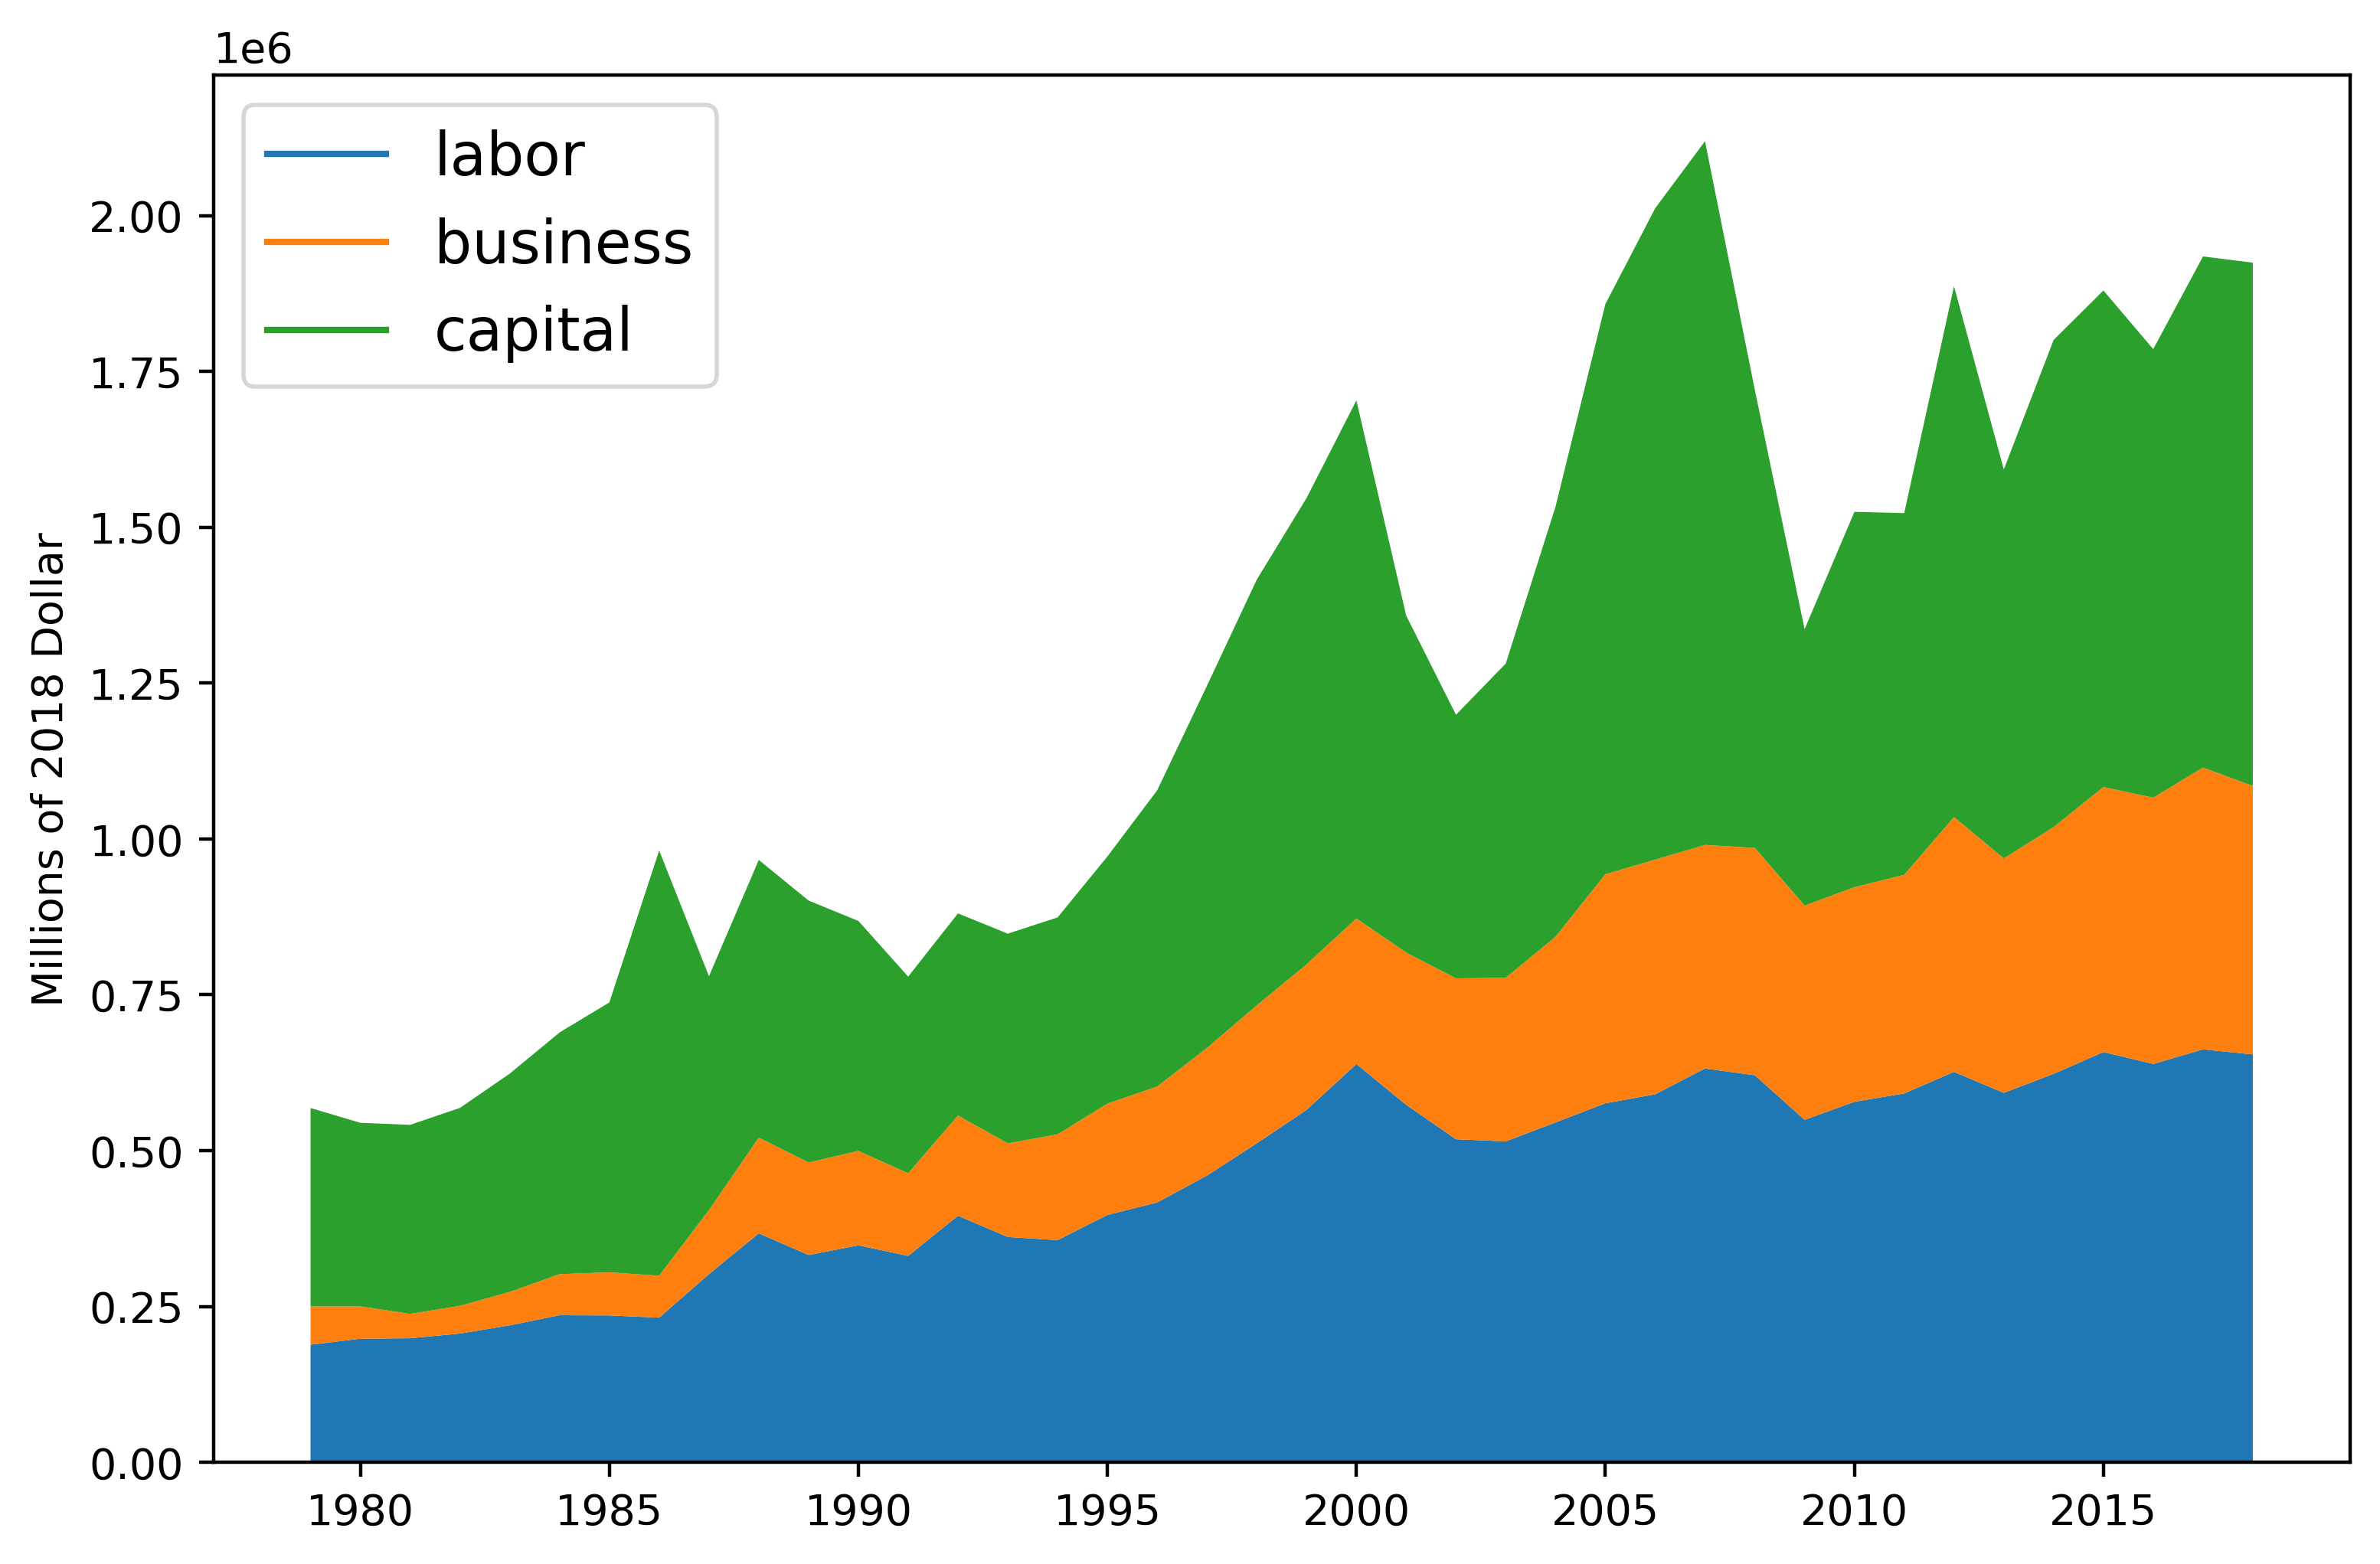

In [56]:
plt.figure(figsize=(9, 6), dpi=400)
plt.plot([], [], color = "tab:blue",
         label ='labor')
plt.plot([], [], color = "tab:orange",
         label ='business')
plt.plot([], [], color = "tab:green",
         label ='capital')


year = income_composition["year"].astype(int)
labor = income_composition["labor"].astype(int)
business = income_composition["business"].astype(int)
capital = income_composition["capital"].astype(int)

plt.stackplot(year, labor, business, capital)
plt.ylabel("Millions of 2018 Dollar")
plt.legend(loc="upper left", fontsize=14)